## Comparing Data with Syngine Synthetics using ObsPy

*Demo by Nick Mancinelli, May 2018*

Useful links:
- [Obspy Documentation](https://docs.obspy.org/)
- [Syngine Documentation](http://ds.iris.edu/ds/products/syngine/)


### Step 1:  Get event catalog from USGS

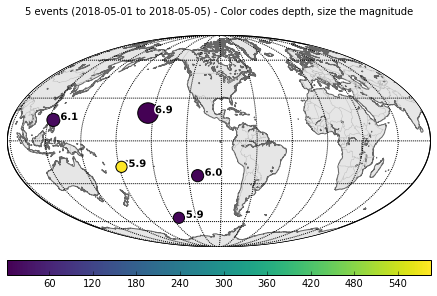

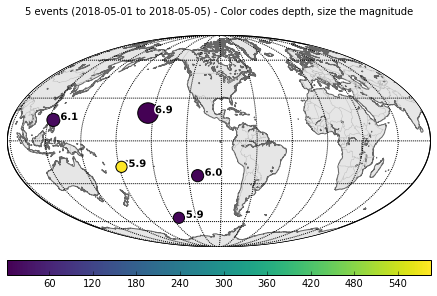

In [1]:
%matplotlib inline
from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime

client = Client('USGS')

starttime = UTCDateTime(2018,5,1)
endtime = UTCDateTime(2018,5,7)
minmagnitude = 5.7

cat = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=minmagnitude)

cat.plot()

### Step 2: Set signal processing workflow
- trim edges
- rotate to ZNE (requires inventory, an obspy class that contains station response info)
- rotate to RT (requires back_azimuth)
- detrend and bandpass filter
- resample

In [2]:
def process_signal(st0, inv, baz):
    st1=st0.copy()
    #trim by 5 sec
    t1=st1[0].stats.starttime+5
    t2=st1[0].stats.endtime-5
    st1.trim(t1,t2)
    st1.rotate('->ZNE',inventory=inv)
    st1.rotate('NE->RT',back_azimuth=baz)
    st1.detrend()
    st1.filter('bandpass', freqmin = 0.005, freqmax =1./10., corners=4, zerophase=True)
    st1.resample(5)
    return(st1)

### Step 3: Get waveforms for Hawaii earthquake
- download data from IRIS
- remove response
- process
- plot

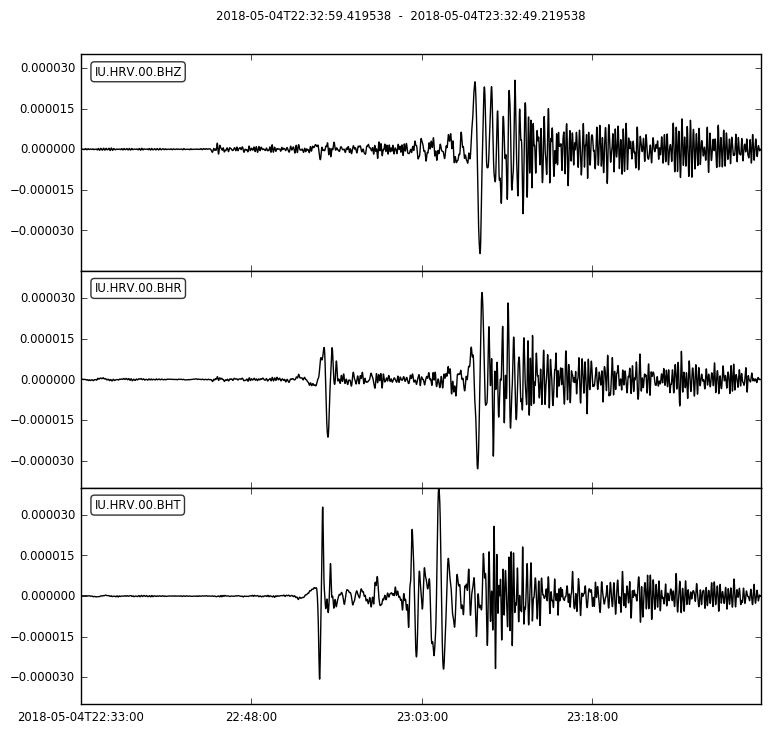

In [3]:
from obspy.geodetics import gps2dist_azimuth

evt = cat[1]
etime, elat, elon = evt.preferred_origin().time, evt.preferred_origin().latitude, evt.preferred_origin().longitude

client = Client("IRIS")

network = 'IU'
station = 'HRV'

inv=client.get_stations(
    starttime=etime,endtime=etime+3600,
    level = "channel", channel="BH*", network=network, station=station)

sta = inv[0][0]

delm, az, baz = gps2dist_azimuth(elat, elon, sta.latitude, sta.longitude)

t1=etime
t2=etime+3600

client = Client('IRIS')

st0=client.get_waveforms(network,station,'00','BH?', t1, t2, attach_response=True)

pre_filt = (0.005, 0.01, 5.0, 10.0)
st0.remove_response(output='DISP', pre_filt=pre_filt)

st1=process_signal(st0, inv = inv, baz = baz)

st1.plot()

### Step 4: Get synthetics for Hawaii earthquake
- Manually input source parameters from [USGS Event Page](https://earthquake.usgs.gov/earthquakes/eventpage/us1000dyad#moment-tensor)
- process
- plot

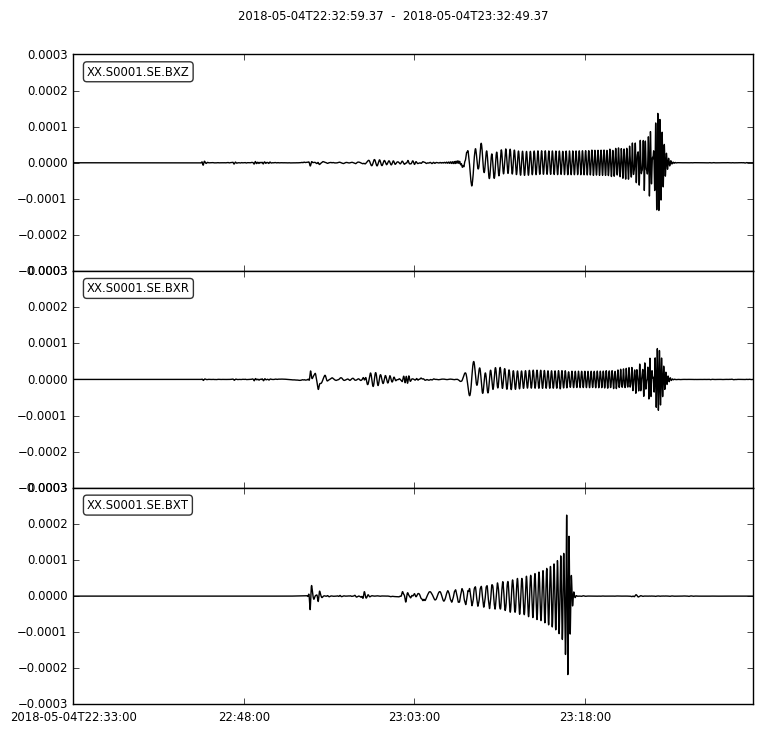

In [4]:
from numpy import arange
from obspy.clients.syngine import Client

elat = evt.preferred_origin().latitude
elon = evt.preferred_origin().longitude
edepth = evt.preferred_origin().depth
etime  = evt.preferred_origin().time

strike = 240
dip = 20
rake= 114
M0 = 2.736e+19

stis = Client().get_waveforms(model="prem_a_2s",
                              sourcelatitude = elat, sourcelongitude = elon,
                              sourcedepthinmeters = edepth,
                              units='displacement',
                              receiverlatitude  = sta.latitude,
                              receiverlongitude = sta.longitude,
                              sourcedoublecouple = [strike, dip, rake, M0],
                              origintime = etime)
    
stis1=process_signal(stis, inv, baz)

stis1.plot()

### Step 5: Compare and plot

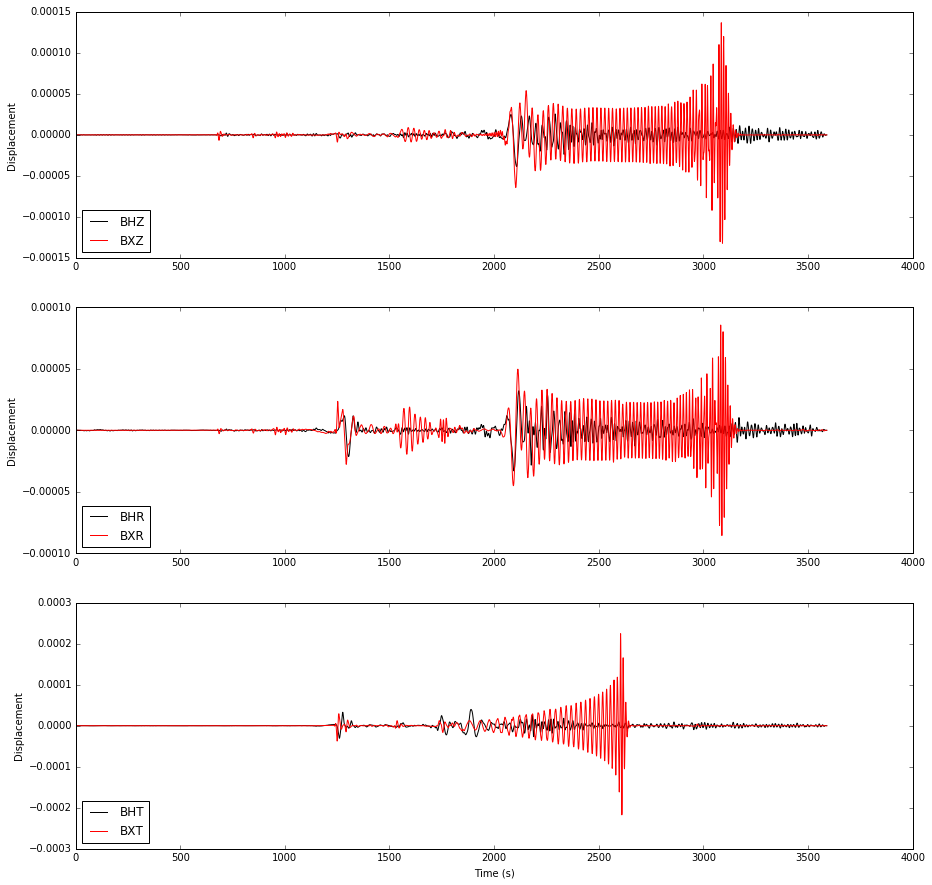

In [5]:
from matplotlib import pylab as plt

def get_index(st,comp):
    for itr, tr in enumerate(st):
        if comp in tr.stats.channel:
            return itr  
    
fig=plt.figure(1,figsize=(15,15))
    
for iplt, comp in enumerate(['Z', 'R', 'T']):
    icomp1 = get_index(st1,comp)
    icomp2 = get_index(stis1,comp)
    
    def plot_trace(trace, color):
        times = arange(len(trace.data)) * trace.stats.delta
        plt.plot(times,trace.data,color,label=trace.stats.channel)
    
    plt.subplot(3,1,iplt+1)
    
    plot_trace(st1  [icomp1],'k')
    plot_trace(stis1[icomp2],'r')
    plt.legend(loc=3)
    plt.ylabel('Displacement')
    
plt.xlabel('Time (s)')

### Future Steps
 - Convolve with source time function